In [83]:
import sys
sys.path.insert(0, "./src")

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
%matplotlib inline
from imageio import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import project_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d
%load_ext autoreload

%autoreload 2
%aimport project_utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load training data

In [ ]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

target_classes = ["healthy", "multiple_diseases", "rust", "scab"]

X_full = project_utils.load_images(df_train)
y_full = np.asarray(df_train[target_classes]).argmax(axis=1)


# Baseline model 1 (Dimensionality reduction + RandomForest)

In [11]:
NUM_PATCHES = 10
IMG_SIZE = (25,25)

model_pca = PCA(n_components=25)

In [105]:
patches_list = []

for img in X_full:
    img_patches = list(extract_patches_2d(img.mean(axis=2), IMG_SIZE, max_patches=NUM_PATCHES, random_state=13))
    patches_list += img_patches

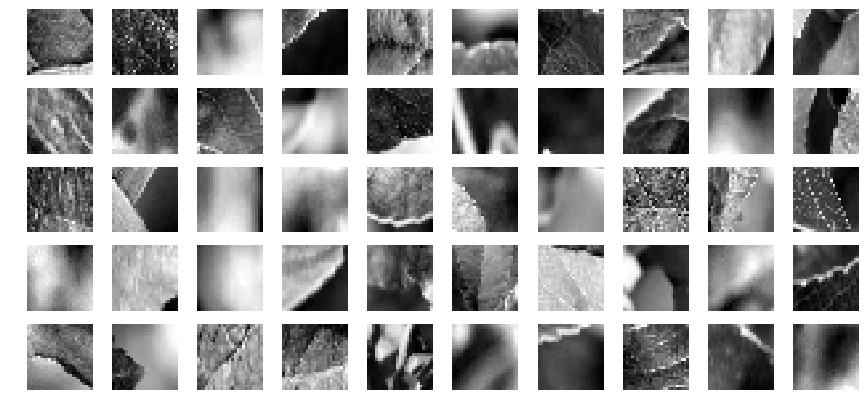

In [111]:
project_utils.plot_patches(patches_list)

In [95]:
patches_list = np.asarray([patch.flatten() for patch in patches_list])
len(patches_list)
patches_transformed = model_pca.fit_transform(patches_list)
patches_inverse = model_pca.inverse_transform(patches_transformed)


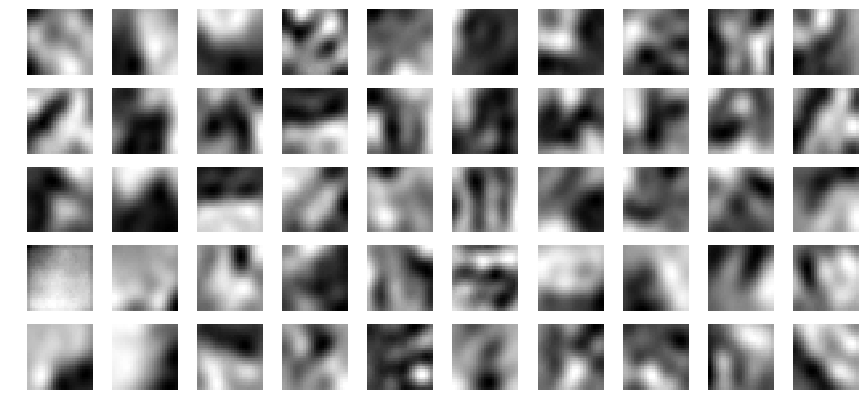

In [109]:
project_utils.plot_patches(patches_inverse.reshape(-1, IMG_SIZE[0], IMG_SIZE[1]))

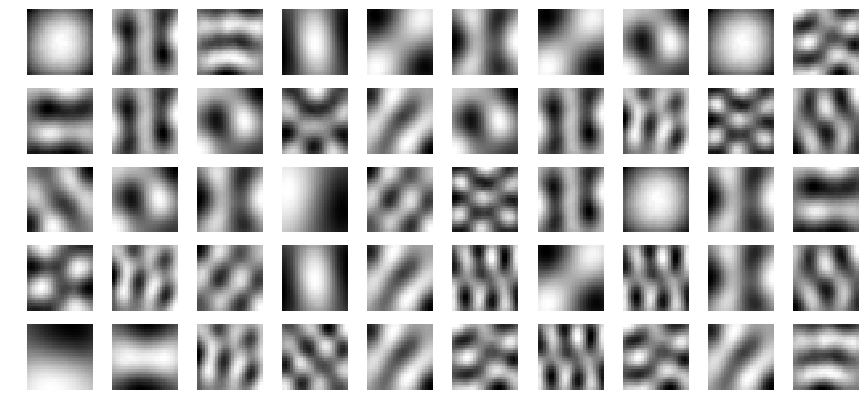

In [110]:
project_utils.plot_patches(model_nmf.components_.reshape(-1, IMG_SIZE[0], IMG_SIZE[1]))

In [98]:
X_train = []

for i in range(0, len(patches_list), NUM_PATCHES):
    X_train.append(model_nmf.transform(patches_list[i:i+NUM_PATCHES]).mean(axis=0))

y_train = y_full

In [99]:
y_train = y_full
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

model_rf = RandomForestClassifier()

model_rf.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Evaluation

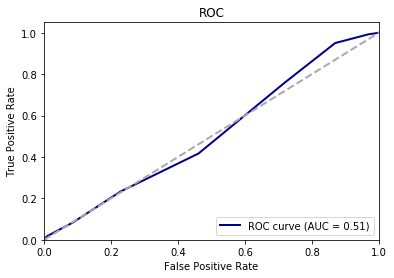

In [100]:
# based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

y = label_binarize(y_test, classes=[0, 1, 2, 3])
y_score = model_rf.predict_proba(X_test)
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr[2], tpr[2], color='darkblue',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# Baseline model 2 (Color features + RandomForest)

In [101]:
X_train = []

for X in X_full:
    
    img_feats = []
    for i in range(3):
        hist, bins = np.histogram(X[:,:,i], bins=100)
        img_feats.append(hist)
    
    X_train.append(np.asarray(img_feats).flatten())
    
X_train = np.asarray(X_train)

In [102]:
y_train = y_full
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

model_rf = RandomForestClassifier()

model_rf.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Evaluation

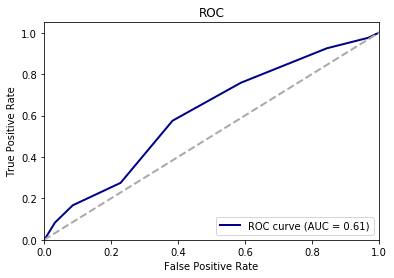

In [103]:
# based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

y = label_binarize(y_test, classes=[0, 1, 2, 3])
y_score = model_rf.predict_proba(X_test)
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr[2], tpr[2], color='darkblue',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()